# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [2]:
from sklearn.datasets import load_iris

iris_data = load_iris()
df = pd.DataFrame(np.c_[ iris_data['data'], iris_data['target'] ],
                    columns=iris_data['feature_names'] + ['target'])

In [3]:
def split_dataset(X, y, test_size, shuffle=True):
    n_samples = X.shape[0]
    permut = np.random.permutation(n_samples) if shuffle else range(n_samples)
    split_point = round((1-test_size)*n_samples)

    X_train, y_train = X[permut[:split_point]], y[permut[:split_point]]
    X_test, y_test = X[permut[split_point:]], y[permut[split_point:]]

    return X_train, X_test, y_train, y_test

In [4]:
def one_hot_encoder(target):
    keys = list(set(target))
    values = list(range(len(keys)))
    class_dict = {key:val for (key, val) in zip(keys, values)}

    target_one_hot = np.zeros((target.shape[0], len(keys)), dtype=int)
    for i, item in enumerate(target):
        target_one_hot[i, class_dict[item]] = 1

    return target_one_hot

In [5]:
X_iris = df.drop(columns=['target']).to_numpy()
y_iris = one_hot_encoder(df['target'].to_numpy())
X_train, X_test, y_train, y_test = split_dataset(X_iris, y_iris, test_size=0.2)

# Model Implementation

In [146]:
class three_layer_nn:
    def __init__(self, n_hidden, X_test, y_test):
        self.n_hidden = n_hidden
        self.X_test = X_test
        self.y_test = y_test

    def initial_weights(self, n_features, n_classes):
        self.w_1 = np.random.random(size=(self.n_hidden, n_features))
        self.b_1 = np.zeros(shape=self.n_hidden)
        self.w_2 = np.random.random(size=(n_classes, self.n_hidden))
        self.b_2 = np.zeros(shape=n_classes)

    def compute_cost(self, y):
        n_samples = y.shape[1]
        loss = -np.sum(y*np.log(self.y_hat), axis=0)
        cost = np.sum(loss) / n_samples

        return cost

    def relu(self, X):
        return np.maximum(X, 0.)

    def relu_grad(self, X):
        X[X<=0] = 0.
        X[X>0] = 1.
        
        return X

    def softmax(self, y_hat):
        y_hat = np.exp(y_hat)
        y_hat = y_hat / np.sum(y_hat, axis=0)

        return y_hat

    def forward_propagation(self, X):
        self.z_1 = self.w_1 @ X + self.b_1.reshape(-1, 1)
        self.a_1 = self.relu(self.z_1)
        self.z_2 = self.w_2 @ self.a_1 + self.b_2.reshape(-1, 1)
        self.y_hat = self.softmax(self.z_2)

    def backpropagation(self, X, y):
        n_samples = X.shape[1]

        self.dz_2 = self.y_hat - y
        self.dw_2 = (self.dz_2 @ self.a_1.T) / n_samples
        self.db_2 = np.sum(self.dz_2, axis=1) / n_samples
        
        self.dz_1 = (self.w_2.T @ self.dz_2) * self.relu_grad(self.z_1)
        self.dw_1 = (self.dz_1 @ X.T) / n_samples
        self.db_1 = np.sum(self.dz_1, axis=1) / n_samples

    def update_params(self, learning_rate):
        self.w_1 = self.w_1 - learning_rate*self.dw_1
        self.b_1 = self.b_1 - learning_rate*self.db_1

        self.w_2 = self.w_2 - learning_rate*self.dw_2
        self.b_2 = self.b_2 - learning_rate*self.db_2

    def train_SGD(self, X, y, learning_rate, epochs, random_state=1, verbose=True):
        np.random.seed(random_state)

        n_features, n_classes, n_samples = X.shape[0], y.shape[0], y.shape[1]

        cost_history = np.zeros(shape=epochs*n_samples)
        acc_history = np.zeros(shape=epochs*n_samples)

        self.initial_weights(n_features, n_classes)

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            for i, index in enumerate(indices):
                X_sample = X[:, index].reshape(-1, 1)
                y_sample = y[:, index].reshape(-1, 1)
                
                self.forward_propagation(X_sample)
                self.backpropagation(X_sample, y_sample)
                self.update_params(learning_rate)

                e = epoch*n_samples + i

                cost_history[e] = self.compute_cost(y_sample)

                y_pred = self.predict(self.X_test)
                acc_history[e] = self.score(self.y_test, y_pred)

                if verbose and ((e+1) % (epochs*n_samples//10) == 0 or e == 0):
                    print(f'iteration: {e+1:>5}/{epochs*n_samples},\tcost: {cost_history[e]:>6.5f}')

        return cost_history, acc_history

    def train_minibatchGD(self, X, y, learning_rate, epochs, batch_size, random_state=1, verbose=True):
        np.random.seed(random_state)

        n_features, n_classes, n_samples = X.shape[0], y.shape[0], y.shape[1]
        n_batches = np.ceil(n_samples/batch_size).astype(int)

        cost_history = np.zeros(shape=epochs*n_batches)
        acc_history = np.zeros(shape=epochs*n_batches)

        self.initial_weights(n_features, n_classes)

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            indices = [indices[i*batch_size:min((i+1)*batch_size, n_samples)] for i in range(n_batches)]
            for i, index in enumerate(indices):
                X_sample = X[:, index]
                y_sample = y[:, index]

                self.forward_propagation(X_sample)
                self.backpropagation(X_sample, y_sample)
                self.update_params(learning_rate)

                e = epoch*n_batches + i

                cost_history[e] = self.compute_cost(y_sample)

                y_pred = self.predict(self.X_test)
                acc_history[e] = self.score(self.y_test, y_pred)

                if verbose and ((e+1) % (epochs*n_batches//10) == 0 or e == 0):
                    print(f'iteration: {e+1:>5}/{epochs*n_batches},\tcost: {cost_history[e]:>6.5f}')

        return cost_history, acc_history

    def train_GD(self, X, y, learning_rate, epochs, random_state=1, verbose=True):
        np.random.seed(random_state)

        n_features, n_classes = X.shape[0], y.shape[0]

        cost_history = np.zeros(shape=epochs)
        acc_history = np.zeros(shape=epochs)

        self.initial_weights(n_features, n_classes)

        for epoch in range(epochs):
            self.forward_propagation(X)
            self.backpropagation(X, y)
            self.update_params(learning_rate)

            cost_history[epoch] = self.compute_cost(y)

            y_pred = self.predict(self.X_test)
            acc_history[epoch] = self.score(self.y_test, y_pred)

            if verbose and((epoch+1) % (epochs//10) == 0 or epoch == 0):
                print(f'iteration: {epoch+1:>5}/{epochs},\tcost: {cost_history[epoch]:>6.5f}')

        return cost_history, acc_history

    def predict(self, X):
        n_classes, n_samples = self.y_hat.shape[0], X.shape[1]

        self.forward_propagation(X)
        pred = np.zeros(shape=(n_classes, n_samples))
        indices = np.argmax(self.y_hat, axis=0)
        for i in range(n_samples):
            pred[indices[i], i] = 1

        return pred

    def score(self, y_true, y_pred):
        n_correct, n_samples = 0, y_true.shape[1]
        for i in range(n_samples):
            if np.all(y_true[:, i] == y_pred[:, i]):
                n_correct += 1

        return n_correct/n_samples

    def plot_history(self, epochs, cost_history, acc_history, title, figsize=(15, 5)):
        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        for h in cost_history:
            plt.plot(list(range(epochs)), h)
        plt.xlabel('Iteration')
        plt.ylabel('Cost')

        plt.subplot(1, 2, 2)
        for h in acc_history:
            plt.plot(list(range(epochs)), h)
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        
        plt.suptitle(title)
        plt.show()

# Model Training

In [147]:
n_hidden = 4
model = three_layer_nn(n_hidden, X_test.T, y_test.T)

## Stochastic Gradient Descent

iteration:     1/1800,	cost: 4.72626
iteration:   180/1800,	cost: 0.92969
iteration:   360/1800,	cost: 0.51479
iteration:   540/1800,	cost: 0.62790
iteration:   720/1800,	cost: 0.47749
iteration:   900/1800,	cost: 0.57112
iteration:  1080/1800,	cost: 0.52994
iteration:  1260/1800,	cost: 0.67328
iteration:  1440/1800,	cost: 0.66396
iteration:  1620/1800,	cost: 0.10260
iteration:  1800/1800,	cost: 0.61117


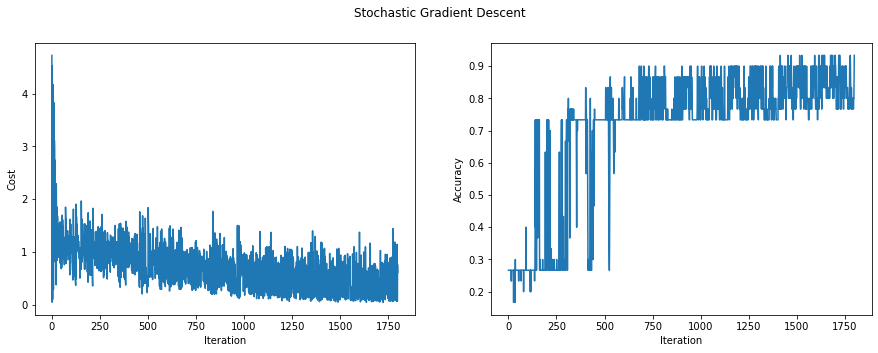

SGD train score: 0.9667
SGD test score: 0.9333


In [148]:
epochs = 15
lr = 0.003

ch_SGD, ah_SGD = model.train_SGD(X_train.T, y_train.T, lr, epochs)

model.plot_history(epochs*X_train.shape[0], [ch_SGD], [ah_SGD], 'Stochastic Gradient Descent')

y_hat_train_SGD = model.predict(X_train.T)
score_train_SGD = model.score(y_train.T, y_hat_train_SGD)
y_hat_test_SGD = model.predict(X_test.T)
score_test_SGD = model.score(y_test.T, y_hat_test_SGD)
print(f'SGD train score: {score_train_SGD:.4}')
print(f'SGD test score: {score_test_SGD:.4}')

## Mini-batch Gradient Descent

iteration:     1/1000,	cost: 3.98900
iteration:   100/1000,	cost: 0.92910
iteration:   200/1000,	cost: 0.66188
iteration:   300/1000,	cost: 0.53260
iteration:   400/1000,	cost: 0.47901
iteration:   500/1000,	cost: 0.32343
iteration:   600/1000,	cost: 0.43886
iteration:   700/1000,	cost: 0.33868
iteration:   800/1000,	cost: 0.29399
iteration:   900/1000,	cost: 0.29453
iteration:  1000/1000,	cost: 0.21423


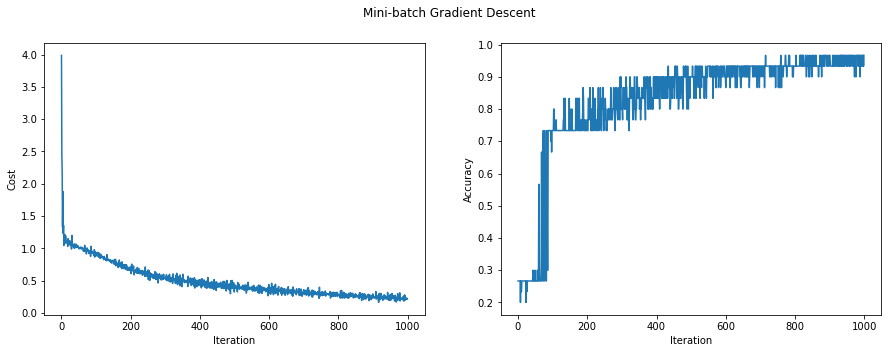

Mini-batch GD train score: 0.9833
Mini-batch GD test score: 0.9667


In [149]:
epochs = 250
lr = 0.01
batch_size = 32
n_batches = np.ceil(X_train.shape[0]/batch_size).astype(int)

ch_BGD, ah_BGD = model.train_minibatchGD(X_train.T, y_train.T, lr, epochs, batch_size)

model.plot_history(epochs*n_batches, [ch_BGD], [ah_BGD], 'Mini-batch Gradient Descent')

y_hat_train_BGD = model.predict(X_train.T)
score_train_BGD = model.score(y_train.T, y_hat_train_BGD)
y_hat_test_BGD = model.predict(X_test.T)
score_test_BGD = model.score(y_test.T, y_hat_test_BGD)
print(f'Mini-batch GD train score: {score_train_BGD:.4}')
print(f'Mini-batch GD test score: {score_test_BGD:.4}')

## Gradient Descent

iteration:     1/5000,	cost: 3.40090
iteration:   500/5000,	cost: 0.40028
iteration:  1000/5000,	cost: 0.21686
iteration:  1500/5000,	cost: 0.13632
iteration:  2000/5000,	cost: 0.10054
iteration:  2500/5000,	cost: 0.08137
iteration:  3000/5000,	cost: 0.06944
iteration:  3500/5000,	cost: 0.06123
iteration:  4000/5000,	cost: 0.05517
iteration:  4500/5000,	cost: 0.05048
iteration:  5000/5000,	cost: 0.04674


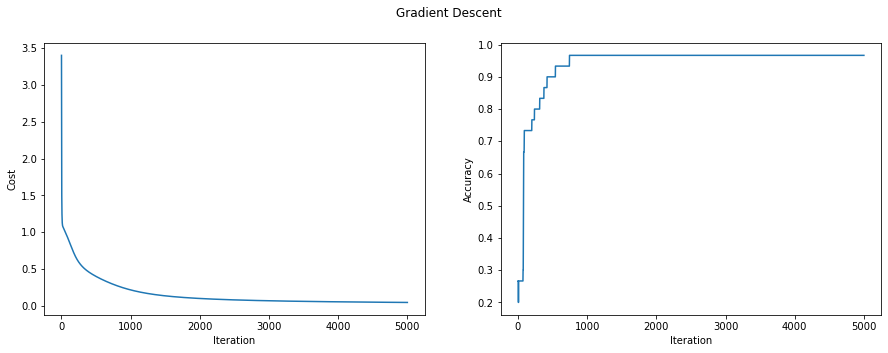

GD train score: 0.9917
GD test score: 0.9667


In [150]:
epochs = 5000
lr = 0.01

ch_GD, ah_GD = model.train_GD(X_train.T, y_train.T, lr, epochs)

model.plot_history(epochs, [ch_GD], [ah_GD], 'Gradient Descent')

y_hat_train_GD = model.predict(X_train.T)
score_train_GD = model.score(y_train.T, y_hat_train_GD)
y_hat_test_GD = model.predict(X_test.T)
score_test_GD = model.score(y_test.T, y_hat_test_GD)
print(f'GD train score: {score_train_GD:.4}')
print(f'GD test score: {score_test_GD:.4}')

## Gradient Descent With Different Starting Point

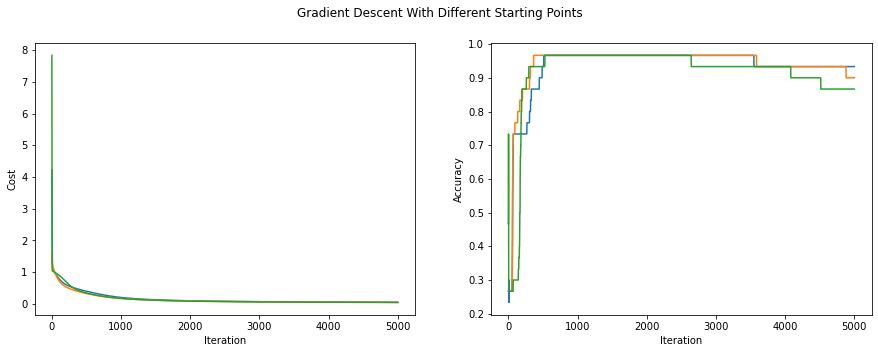

GD1 train score: 0.9917, GD1 test score: 0.9333
GD2 train score: 0.9917, GD1 test score: 0.9
GD3 train score: 0.9917, GD1 test score: 0.8667


In [154]:
epochs = 5000
lr = 0.01

diff_points = 3
random_states = np.random.randint(65535, size=diff_points)

ch_GD_ = []
ah_GD_ = []
y_hat_train_GD_ = []
score_train_GD_ = []
y_hat_test_GD_ = []
score_test_GD_ = []

for i in range(diff_points):
    ch, ah = model.train_GD(X_train.T, y_train.T, lr, epochs, random_states[i], verbose=False)
    ch_GD_.append(ch)
    ah_GD_.append(ah)
    y_hat_train_GD_.append(model.predict(X_train.T))
    score_train_GD_.append(model.score(y_train.T, y_hat_train_GD_[i]))
    y_hat_test_GD_.append(model.predict(X_test.T))
    score_test_GD_.append(model.score(y_test.T, y_hat_test_GD_[i]))

model.plot_history(epochs, ch_GD_, ah_GD_, 'Gradient Descent With Different Starting Points')

for i in range(diff_points):
    print(f'GD{i+1} train score: {score_train_GD_[i]:.4}, GD1 test score: {score_test_GD_[i]:.4}')

## Gradient Checking

In [161]:
test = three_layer_nn(n_hidden=5, X_test=None, y_test=None)
eps = 0.00001

In [162]:
test.initial_weights(X_train.shape[1], y_train.shape[1])

test.forward_propagation(X_train.T)
test.backpropagation(X_train.T, y_train.T)

d1 = np.sum(test.dw_1)

test.w_1 += eps
test.forward_propagation(X_train.T)
c1 = test.compute_cost(y_train.T)

test.w_1 -= 2*eps
test.forward_propagation(X_train.T)
c2 = test.compute_cost(y_train.T)

d2 = (c1 - c2)/(2*eps)

diff_w1 = np.abs(d1 - d2)

In [163]:
test.initial_weights(X_train.shape[1], y_train.shape[1])

test.forward_propagation(X_train.T)
test.backpropagation(X_train.T, y_train.T)

d1 = np.sum(test.db_1)

test.b_1 += eps
test.forward_propagation(X_train.T)
c1 = test.compute_cost(y_train.T)

test.b_1 -= 2*eps
test.forward_propagation(X_train.T)
c2 = test.compute_cost(y_train.T)

d2 = (c1 - c2)/(2*eps)

diff_b1 = np.abs(d1 - d2)

In [164]:
test.initial_weights(X_train.shape[1], y_train.shape[1])

test.forward_propagation(X_train.T)
test.backpropagation(X_train.T, y_train.T)

d1 = np.sum(test.dw_2)

test.w_2 += eps
test.forward_propagation(X_train.T)
c1 = test.compute_cost(y_train.T)

test.w_2 -= 2*eps
test.forward_propagation(X_train.T)
c2 = test.compute_cost(y_train.T)

d2 = (c1 - c2)/(2*eps)

diff_w2 = np.abs(d1 - d2)

In [165]:
test.initial_weights(X_train.shape[1], y_train.shape[1])

test.forward_propagation(X_train.T)
test.backpropagation(X_train.T, y_train.T)

d1 = np.sum(test.db_2)

test.b_2 += eps
test.forward_propagation(X_train.T)
c1 = test.compute_cost(y_train.T)

test.b_2 -= 2*eps
test.forward_propagation(X_train.T)
c2 = test.compute_cost(y_train.T)

d2 = (c1 - c2)/(2*eps)

diff_b2 = np.abs(d1 - d2)

In [166]:
diff_w1, diff_b1, diff_w2, diff_b2

(8.245137905760203e-11,
 5.601796804199921e-12,
 1.3322676295501878e-15,
 2.7755575615628914e-17)